# Model Selection
Evaluating and selecting algorithms and hyperparameters.

In [2]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Evaluating models
To know whether we can _trust_ what our algorithm has learned, we need to evaluate it.

We will focus on supervised methods (classification and regression)
- With the labels we can objectively evaluate models
- There are still many ways to do this

In unsupervised learning (e.g. clustering) we don't know what the 'right' output should be
- We can only optimize for certain properties (e.g. cluster purity)
- Ultimately, we need to inspect results manually (or create an external evaluation measure)

## The holdout (simple train-test split)
We've already seen the most basic form of evaluation:

- Split data into training and test set (75%-25%)
    - In sklearn we split in training and test predictors (X_train, X_test) and labels (y_train, y_test)
- Train (fit) a model on the training data
- Score a model on the test data (comparing predicted and true labels)
    - We are interested in how well the model _generalizes_ to new (test) data

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(centers=2, random_state=0)
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Instantiate a model and fit it to the training set
lr = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Test set score: 0.92


Visualized

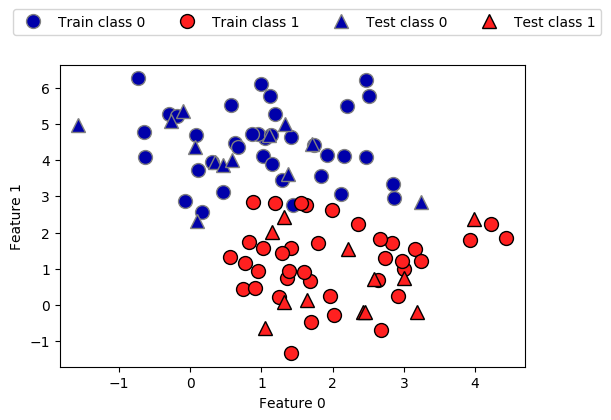

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                         markers='o', ax=ax)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                         markers='^', ax=ax)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.legend(["Train class 0", "Train class 1", "Test class 0",
                "Test class 1"], ncol=4,  loc=(-0.1, 1.1));

Limitations to this approach:

* Why 75%? Are there better ways to split?
* What if one random split yields different models (and scores) than another?
* What if all examples of one class all end up in the training/test set?

## Cross-validation

- More stable, thorough way to estimate generalization performance
- _k-fold cross-validation_ (CV): split (randomized) data into _k_ equal-sized parts, called _folds_
    - First, fold 1 is the test set, and folds 2-5 comprise the training set
    - Then, fold 2 is the test set, folds 1,3,4,5 comprise the training set
    - Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)

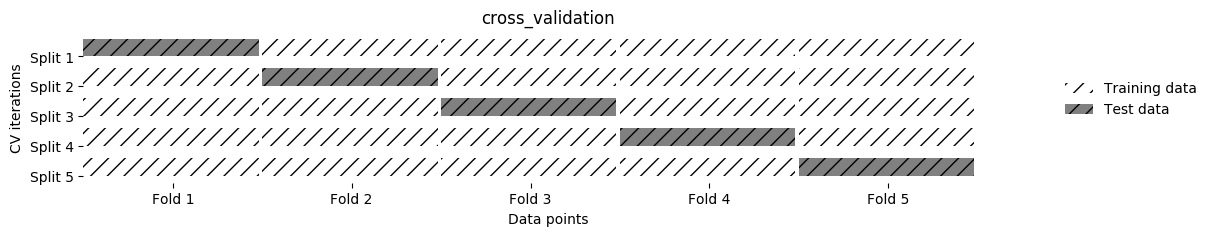

In [5]:
mglearn.plots.plot_cross_validation()

### Cross-validation in scikit-learn

- `cross_val_score` function with learner, training data, labels
- Returns list of all scores
    - Does 3-fold CV by default
    - Default scoring measures are accuracy (classification) or $R^2$ (regression)
- Even though models are built internally, they are not returned

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.961 0.922 0.958]


- Change the number of folds with `cv` parameter
- Note that there can be quite some _variance_ in the results
    - Depends on the stability of the model and the amount of training data
    - Typically, the more training data, the more stable the models

In [7]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross validation scores: {}".format(scores))

Cross validation scores: [1.    0.967 0.933 0.9   1.   ]


- Aggregate the scores yourself (e.g. mean)
- This means that the model is 96% accurate _on average_

In [8]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))
print("Variance in cross-validation score: {:.4f}".format(np.var(scores)))

Average cross-validation score: 0.96
Variance in cross-validation score: 0.0015


### Benefits of cross-validation
- More robust: every training example will be in a test set exactly once
    - Model is evaluated on all samples, needs to do well on all
    - With a train-test split, we can be
        - 'lucky': all easy examples in test set
        - 'unlucky: all hard examples in test set
- Shows how _sensitive_ the model is to the exact training set
- Better estimation of true performance
    - 10-fold CV uses 90% of all data for training (vs 75% for holdout)
    - The higher _k_, the more accurate the estimation
- Disadvantage: computational cost, roughly _k_ times slower than holdout

### Stratified K-Fold cross-validation

- If the data is _unbalanced_, some classes have many fewer samples
- Likely that some classes are not present in the test set 
- Stratification: make sure that _proportions_ between classes are conserved in each fold
    - Order examples per class
    - Separate the samples of each class in _k_ sets (strata)
    - Combine corresponding strate into folds

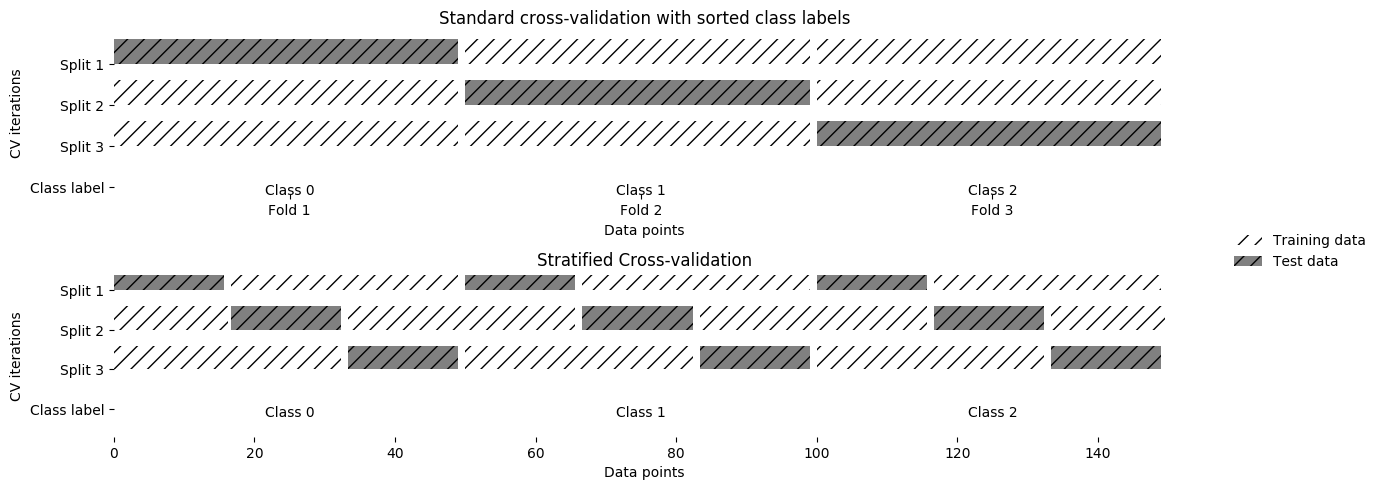

In [9]:
mglearn.plots.plot_stratified_cross_validation()

- scikit-learn (e.g. `cross_val_score`) will use:
    - stratified cross-validation by default for classification
    - normal cross-validation for regression
    - both are non-randomized (samples are not shuffled beforehand)
        - ordered data (e.g. time series) should never be randomized
- You can build folds manually with `KFold`
    - randomizable (`shuffle` parameter), non-stratified (!)
- Or `StratifiedKFold`
    - randomizable (`shuffle` parameter), stratified

In [76]:
from sklearn.model_selection import KFold, StratifiedKFold
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.    0.7   0.    0.967 0.   ]


In [77]:
# Can you explain this result?
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


In [79]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0) 
print("Cross-validation scores (shuffled, not stratified):\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0) 
print("Cross-validation scores (shuffled, stratified):\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=skfold)))
print("Cross-validation scores (default: stratified, not shuffled):\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=3)))

Cross-validation scores (shuffled, not stratified):
[0.66 0.96 0.84]
Cross-validation scores (shuffled, stratified):
[0.784 0.863 0.792]
Cross-validation scores (default: stratified, not shuffled):
[0.804 0.863 0.771]


### Leave-One-Out cross-validation

- _k_ fold cross-validation with _k_ equal to the number of samples
- Completely unbiased (in terms of data splits), but computationally expensive
- But: generalizes _less_ well towards unseen data
    - The training sets are correlated (overlap heavily)
    - Overfits on the data used for (the entire) evaluation
- Recommended for small datasets

In [13]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


### Shuffle-Split cross-validation

- Samples a number of samples (`train_size`) randomly as the training set, and a disjoint number of samples (`test_size`) as the test set
- Repeat this procedure `n_iter` times, obtaining `n_iter` scores
- Typically, the whole dataset is used each iteration (except for large datasets)
- Example with `train_size` = 5, `test_size` = 2, `n_iter` = 4

![shuffle_split](images/03_shuffle_split.png)

- In scikit-learn, `train_size` and `test_size` can be absolute numbers or a percentage of the total dataset
- Stratified variant: `StratifiedShuffleSplit' (recommended for classification)

In [14]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.88  0.947 0.973 0.867 0.987 0.96  0.973 0.867 0.933 0.853]


Note: this is related to _bootstrapping_:
- Sample _n_ (total number of samples) data points, with replacement, as training set (the bootstrap)
- Use the unsampled (out-of-bootstrap) samples as the test set
- Repeat `n_iter` times, obtaining `n_iter` scores
- Not supported in scikit-learn, use Shuffle-Split instead.
    - With `train_size=0.66`, `test_size=0.34`
    - You can prove that bootstraps include 66% of all data points on average 

### Repeated cross-validation
- Cross-validation is still biased in that the initial split can be made in many ways
- Repeated, or n-times-k-fold cross-validation:
    - Shuffle data randomly, do k-fold cross-validation
    - Repeat n times, yields n times k scores
- Unbiased, very robust, but n times more expensive

### Cross-validation with groups

- Sometimes the data contains inherent groups:
    - Blood analysis results on specific patients
    - Facial expressions of specific people
- With normal cross-validation, data from the same persion may end up in the training _and_ test set
- If we want to measure how well the model generalizes to _other_ people, this is undesirable
- We want to make sure that data points fom one person are in _either_ the training or test set
    - This is called _grouping_ or _blocking_
    - Leave-one-subject-out cross-validation: create test set for each user individually

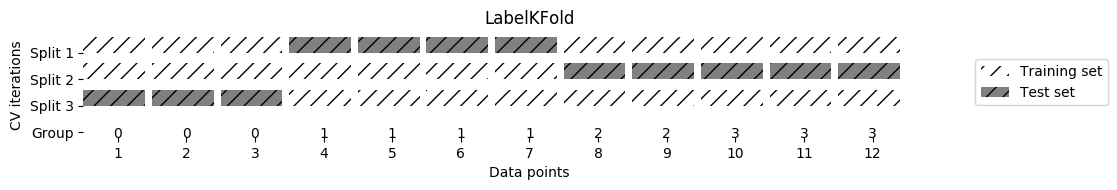

In [15]:
mglearn.plots.plot_group_kfold()

- In scikit-learn, this is supported by `GroupKFold`
    - Add an array with group membership to `cross_val_scores` 
    - Use `GroupKFold` with the number of groups as CV procedure

In [16]:
from sklearn.model_selection import GroupKFold
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75  0.8   0.667]


### Choosing a performance estimation procedure
No strict rules, only guidelines:

- Always use stratification for classification
- Use holdout for very large datasets (e.g. >1.000.000 examples)
    - Or when learners don't always converge (e.g. deep learning)
- Choose _k_ depending on dataset size and resources
    - Use leave-one-out for small datasets (e.g. <500 examples)
    - Use cross-validation otherwise
        - Most popular (and theoretically sound): 10-fold CV
        - Literature suggests 5x2-fold CV is better
- Use grouping or leave-one-subject-out for grouped data

## Bias-Variance decomposition

- When we repeat evaluation procedures multiple times, we can distinguish two sources of errors:
    - Bias: systematic error (independent of the training sample). The classifier always gets certain points wrong
    - Variance: error due to variability of the model with respect to the training sample. The classifier predicts some points accurately on some training sets, but inaccurately on others.
- There is also an intrinsic (noise) error, but there's nothing we can do against that.
- Bias is associated with underfitting, and variance with overfitting
- Bias-variance trade-off: you can often exchange bias for variance through (de)regularization
    - The challenge is to find the right trade-off (minimizing total error)
- Useful to understand how to tune or adapt learning algorithm

- Sadly, this is not yet supported by scikit-learn
- How to measure bias and variance (for regression):
    - Take 100 or more bootstraps (or shuffle-splits)
    - For each data point x:
        - $bias(x) = (x_{true} - mean(x_{predicted}))^2$
        - $variance(x) = var(x_{predicted})$
    - Total bias: $\sum_{x} bias(x) * w_x$, with $w_x$ the ratio of x occuring in the test set
    - Total variance: $\sum_{x} variance(x) * w_x$

![Bias-variance](images/03_bias_variance.png)

- General procedure for (binary) classification:
    - Take 100 or more bootstraps (or shuffle-splits)
    - Bias for any point x = misclassification ratio
        - If misclassified 50% of the time: $bias(x)=0.5$
    - Variance for any point x is $(1 - (P(class_1)^2 + P(class_2)^2))/2$
        - $P(class_i)$ is ratio of class $i$ predictions
        - When each class predicted half of the time: $variance(x) = (1-(0.5^2+0.5^2))/2 = 0.25$
    - Total bias: $\sum_{x} bias(x)^2 * w_x$, with $w_x$ the ratio of x occuring in the test data
    - Total variance: $\sum_{x} variance(x) * w_x$

In [17]:
# Data and classifier
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)
clf = LogisticRegression()

# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

# Store sample predictions
y_all_pred = [[] for _ in range(len(y))]

# Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])

    # Store predictions
    for i,index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])
        
# Compute bias, variance, error
bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(y_all_pred)])
error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

print("Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (bias_sq, var, error))

Bias squared: 14.35, Variance: 0.75, Total error: 15.10


### Bias-variance and overfitting
![Bias-variance-tradeoff](images/03_Bias-Variance-Tradeoff.png)

- High bias means that you are likely underfitting
    - Do less regularization
    - Use a more flexible/complex model (another algorithm)
    - Use a bias-reduction technique (boosting)
- High variance means that you are likely overfitting
    - Use more regularization
    - Get more data
    - Use a simpler model (another algorithm)
    - Use a variance-reduction techniques (bagging)
- Boosting and Bagging will be explained later

Bias-Variance Flowchart (Andrew Ng, Coursera)
![Bias-variance-Flowchart](images/03_Bias-Variance-Flowchart.png)

## Hyperparameter tuning
Now that we know how to evaluate models, we can improve them by tuning their hyperparameters

We can basically use any optimization technique to optimize hyperparameters:
    
- __Grid search__
- __Random search__
- Local search
- Racing algorithms
- __Model-based optimization__
- Multi-armed bandits
- Genetic algorithms

### Grid Search

- For each hyperparameter, create a list of interesting/possible values
    - E.g. For kNN: k in [1,3,5,7,9,11,33,55,77,99]
- Evaluate all possible combination of hyperparameter values
    - E.g. using cross-validation
- Select the hyperparameter values yielding the best results

A naive approach would be to just loop over all combinations  
Note: we've seen the `C` parameter of SVMs, we'll see the `gamma` parameter later.

In [18]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C);
        svm.fit(X_train, y_train);
        # evaluate the SVC on the test set 
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


#### Overfitting the parameters and the validation set
- Simply taking the best performing model yields optimistic results
- We've already used the test data to evaluate each hyperparameter setting
- Hence, we don't have an independent test set to evaluate these hyperparameter settings
    - Information 'leaks' from test set into the final model
- Solution: Set aside part of the training data to evaluate the hyperparameter settings
    - Select best hyperparameters on validation set
    - Rebuild the model on the training+validation set
    - Evaluate optimal model on the test set

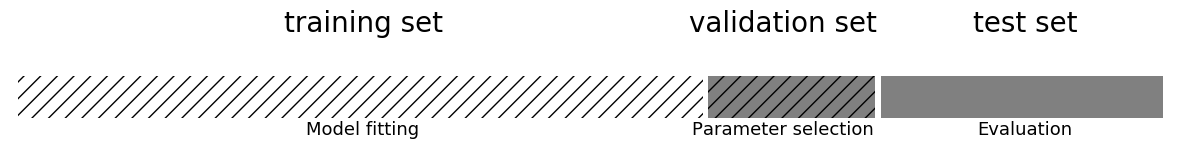

In [19]:
mglearn.plots.plot_threefold_split()

In [20]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set 
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


#### Grid-search with cross-validation

- Same problem as before: the way that we split the data into training, validation, and test set may have a large influence on estimated performance
- We need to use cross-validation again, instead of a single split
- Expensive. Often, 5-fold CV is enough, or a shuffle_split with `n_iter=1` 

In [21]:
# manual grid search cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Overall process

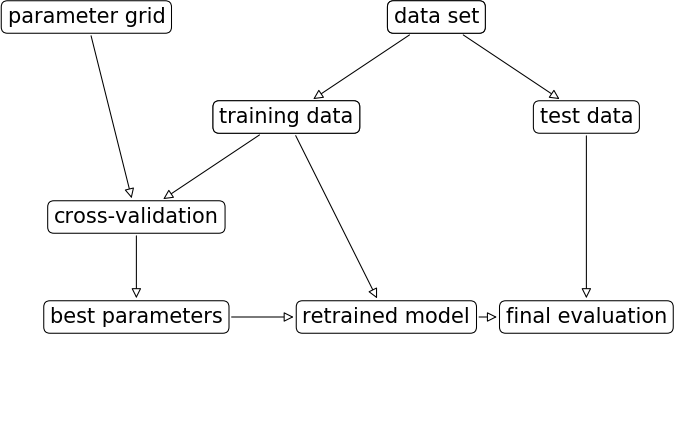

In [69]:
plt.rcParams['savefig.dpi'] = 75 # Avoid overlapping boxes
mglearn.plots.plot_grid_search_overview()

In [70]:
plt.rcParams['savefig.dpi'] = 100 # Back to normal

#### Grid search in scikit-learn
- Create a parameter grid as a dictionary
    - Keys are parameter names
    - Values are lists of hyperparameter values

In [23]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- `GridSearchCV`: like a classifier that uses CV to automatically optimize its hyperparameters internally
    - Input: (untrained) model, parameter grid, CV procedure
    - Output: optimized model on given training data
    - Should only have access to trinaing data

In [24]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The optimized test score and hyperparameters can easily be retrieved:

In [25]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [26]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


In [27]:
# Not really necessary because grid_search can also predict and score
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Visualizing hyperparameter impact
We can retrieve and visualize the cross-validation resulst to better understand the impact of hyperparameters

In [28]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
# Show the first 5 rows
display(results.head())

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,...,std_fit_time,std_score_time,std_test_score,std_train_score
0,6.84e-04,2.75e-04,0.37,0.37,...,2.48e-04,8.84e-05,0.01,2.85e-03
1,5.68e-04,2.36e-04,0.37,0.37,...,4.18e-05,2.65e-05,0.01,2.85e-03
2,5.16e-04,2.12e-04,0.37,0.37,...,8.66e-06,2.95e-06,0.01,2.85e-03
3,5.17e-04,2.11e-04,0.37,0.37,...,1.94e-05,2.88e-06,0.01,2.85e-03
4,5.01e-04,2.05e-04,0.37,0.37,...,9.35e-06,1.39e-06,0.01,2.85e-03


Visualize as a heatmap

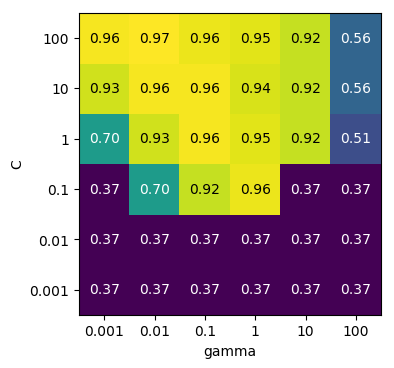

In [29]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis");

When hyperparameters depend on other parameters, we can use lists of dictionaries to define the hyperparameter space

In [30]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


#### Nested cross-validation

- Note that we are still using a single split to create the outer test set
- We can also use cross-validation here
- Nested cross-validation:
    - Outer loop: split data in training and test sets
    - Inner loop: run grid search, splitting the training data into train and validation sets
- Result is a just a list of scores
    - There will be multiple optimized models and hyperparameter settings (not returned)
- To apply on future data, we need to train `GridSearchCV` on all data again

In [31]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.967 1.    0.9   0.967 1.   ]
Mean cross-validation score:  0.9666666666666668


#### Parallelizing cross-validation and grid-search
- On a practical note, it is easy to parallellize CV and grid search
- `cross_val_score` and `GridSearchCV` have a `n_jobs` parameter defining the number of cores it can use.
    - set it to `n_jobs=-1` to use all available cores.

### Random Search

- Grid Search has a few downsides:
    - Optimizing many hyperparameters creates a combinatorial explosion
    - You have to predefine a grid, hence you may jump over optimal values
- Random Search:
    - Picks `n_iter` random parameter values
    - Scales better, you control the number of iterations
    - Often works better in practice, too
        - not all hyperparameters interact strongly
        - you don't need to explore all combinations

- Executing random search in scikit-learn:
    - `RandomizedSearchCV` works like `GridSearchCV`
    - Has `n_iter` parameter for the number of iterations
    - Search grid can use distributions instead of fixed lists

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11c332780>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11c332438>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

# Summary

- k-fold Cross-validation
    - Choose k depending on how much data you have
        - Larger k is slower, but allows more training data
        - 10-fold, 5-fold, 5x2-fold most popular
    - Always use stratification for (imbalanced) classification
    - Train-test split and Shuffle-split: useful for large datasets 
    - Use grouping when you want to generalize over groups
- Model selection
    - Don't aggregate over test scores: those have seen the test data
    - Use validation sets to choose algorithms/hyperparameters first
- Optimization
    - Grid Search: exhaustive but simple
    - Random Search: scales better
    - We'll see more advanced techniques later